## FACT: There are over 127 million acres of agricultural land in the Midwest and in addition to 75% of that area in corn  and soybeans, the other 25% is used to produce alfalfa, apples, asparagus, green beans, blueberries,   cabbage, carrots, sweet and tart cherries, cranberries, cucumbers, grapes, oats, onions, peaches, plums,  peas, bell peppers, potatoes, pumpkins, raspberries, strawberries, sweet corn, tobacco, tomatoes, watermelon, and wheat.

In [1]:
#https://www.investopedia.com/terms/v/vwap.asp
#https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca

# Recurrent Neural Network

#https://www.youtube.com/watch?v=zwqwlR48ztQ

# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('./marketdata/zsh20.csv')
dataset_chy = pd.read_csv('./marketdata/DEXCHUS.csv')
dataset_train = pd.merge(dataset_train, dataset_chy,  left_on='Time', right_on='Time', how='left')
dataset_dxy = pd.read_csv('./marketdata/DTWEXB.csv')
dataset_train = pd.merge(dataset_train, dataset_dxy,  left_on='Time', right_on='Time', how='left')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]
#dataset_train = dataset_train.iloc[21:] #remove first 21 rows
dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.set_index('Time', inplace=True)
dataset_train.shape

(490, 9)

In [2]:
dataset_train.head()

,Open,High,Low,Last,Change,Volume,Open Int,DEXCHUS,DTWEXB
Time,,,,,,,,,
2017-11-15,985.0,985.0,985.0,985.0,6.5,0,0,6.6200,120.5898
2017-11-16,983.0,983.0,983.0,983.0,-2.0,0,0,6.6273,120.3562
2017-11-17,996.5,996.5,996.5,996.5,13.5,0,0,6.6245,120.0765
2017-11-20,998.5,998.5,998.5,998.5,2.0,0,0,6.6245,120.3473
2017-11-21,998.0,998.0,998.0,998.0,-0.5,0,0,6.6265,120.0523


In [3]:
dataset_train.columns

Index(['Open', 'High', 'Low', 'Last', 'Change', 'Volume', 'Open Int',
       'DEXCHUS', 'DTWEXB'],
      dtype='object')

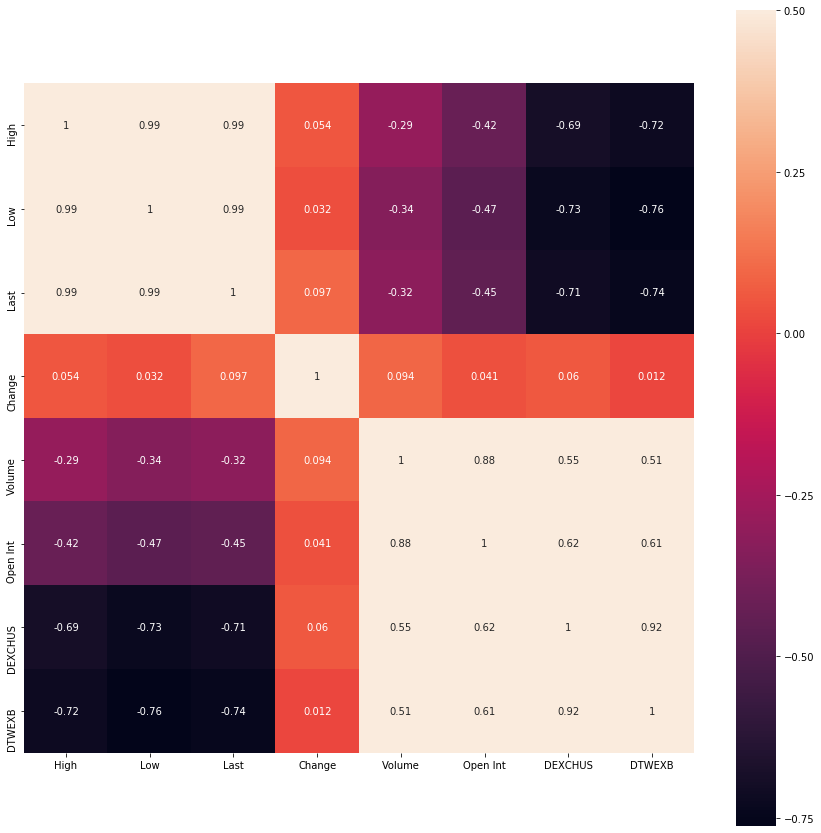

In [4]:
import seaborn as sns
fcol = [c for c in dataset_train.columns if c not in ['Time', 'Open']]

C_mat = dataset_train[fcol].corr()
fig = plt.figure(figsize=(15,15))
sns.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

In [5]:
training_set = dataset_train.iloc[:, 1:9].values
training_set[0,7]

120.5898

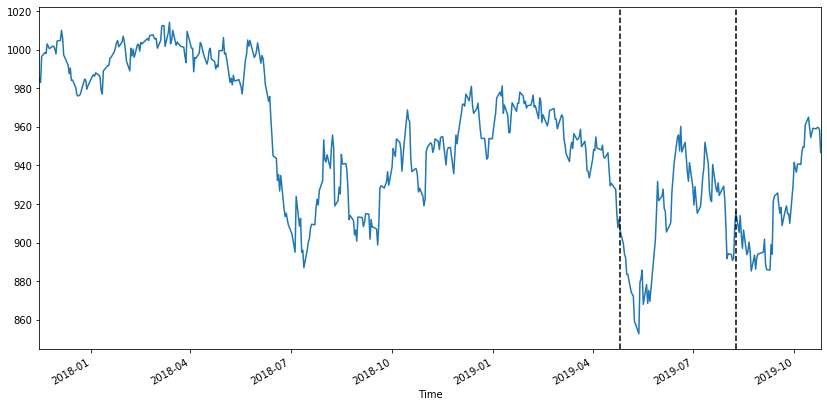

In [6]:
ax = dataset_train["Last"].plot(figsize=(14, 7))
ax.axvline("26-04-2019", linestyle="--", c="black")
ax.axvline("08-09-2019", linestyle="--", c="black")

In [7]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Creating a data structure with 15 timesteps and 1 output - we use last 15 prices to predict next. 
#This takes data from 15th row onwards
X_whole = []
y_whole = []
sequence_size = 2
for i in range(sequence_size, len(training_set_scaled)):
    X_whole = np.append(X_whole, training_set_scaled[i-sequence_size:i, 0])
    #X_whole = np.append(X_whole, training_set_scaled[i, 6])
    #X_whole = np.append(X_whole, training_set_scaled[i, 7])
    vwap = 0
    vol = 0
    vchg = 0
    for j in range(sequence_size):
        if (j+i<training_set_scaled.shape[0]):
            vwap += (((np.sum(training_set_scaled[j+i, 0:3]))/3) * training_set_scaled[j+i, 4])
            vchg += (((training_set_scaled[j+i, 3])) * training_set_scaled[j+i, 4])
            vol += training_set_scaled[j+i, 4]
    #if vwap !=0  and vol != 0:
    X_whole = np.append(X_whole, vwap/vol)
    X_whole = np.append(X_whole, vchg/vol)
    y_whole.append(training_set_scaled[i, 0])

sz = training_set_scaled.shape[0]-sequence_size
X_whole, y_whole = np.array(X_whole.reshape(sz,sequence_size+2)), np.array(y_whole)

In [9]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

In [10]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [11]:
%%time
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressor.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Fitting the RNN to the Training set
hist = regressor.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 120, batch_size = 8, verbose=0)

Using TensorFlow backend.


Wall time: 40.2 s


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


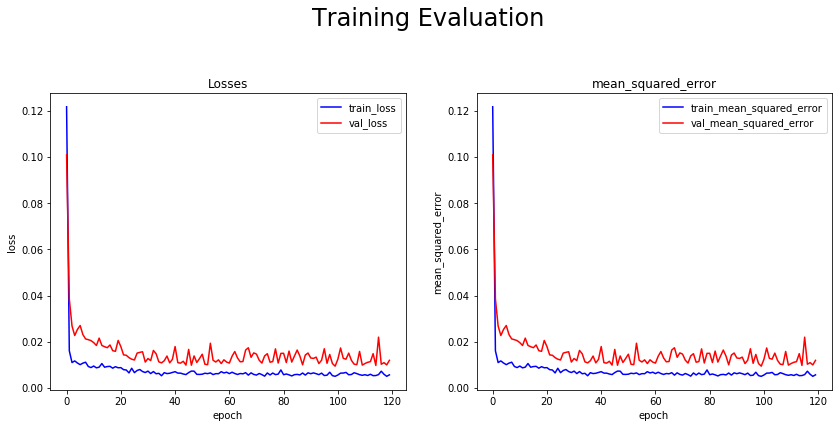

In [12]:
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [13]:
y_test.shape

(68,)

In [14]:
#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 8) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]
real_stock_price

array([930.82109005, 933.37243286, 934.1378357 , 929.03515008,
       931.58649289, 928.52488152, 923.42219589, 906.32819905,
       895.86769352, 897.14336493, 894.8471564 , 891.78554502,
       906.83846761, 916.5335703 , 914.49249605, 920.36058452,
       916.27843602, 908.11413902, 904.79739336, 901.73578199,
       899.18443918, 900.97037915, 906.58333333, 896.37796209,
       895.35742496, 889.48933649, 891.53041074, 895.10229068,
       900.97037915, 893.06121643, 903.26658768, 902.50118483,
       890.7650079 , 886.6828594 , 899.18443918, 897.65363349,
       919.85031596, 926.99407583, 928.01461295, 923.93246445,
       921.12598736, 918.82977883, 916.5335703 , 921.38112164,
       921.38112164, 920.10545024, 920.36058452, 913.21682464,
       929.29028436, 940.26105845, 939.49565561, 941.28159558,
       943.57780411, 942.04699842, 948.42535545, 956.07938389,
       957.61018957, 963.47827804, 967.56042654, 967.56042654,
       962.45774092, 965.00908373, 962.96800948, 965.00

sqrt mean_squared_error:  7.368061657167729
mean_squared_error:  54.288332583825266
mean_absolute_error:  5.285482540749479


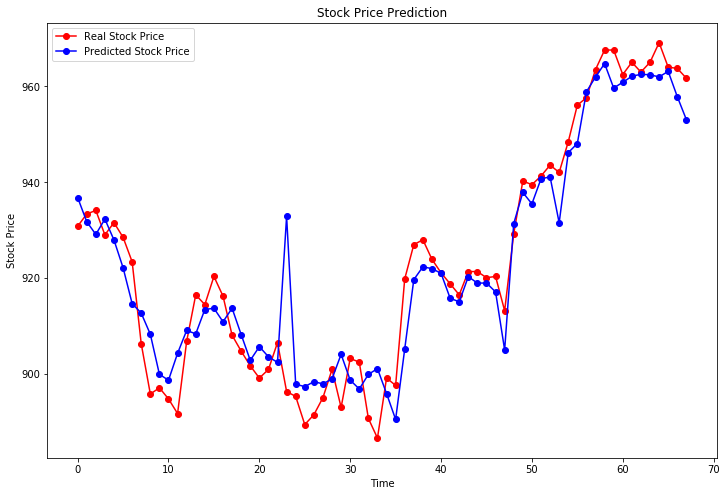

In [15]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
# create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(predicted_stock_price), 8) )
test_data[:,2] = predicted_stock_price.reshape(1,-1)
predicted_stock_price = sc.inverse_transform(test_data)[:,2]

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[01:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9951737613432566 0.9724324526722353
0.05042650050495067
sqrt mean_squared_error:  4.071939915774757
mean_squared_error:  16.580694677679737
mean_absolute_error:  2.941466279742776


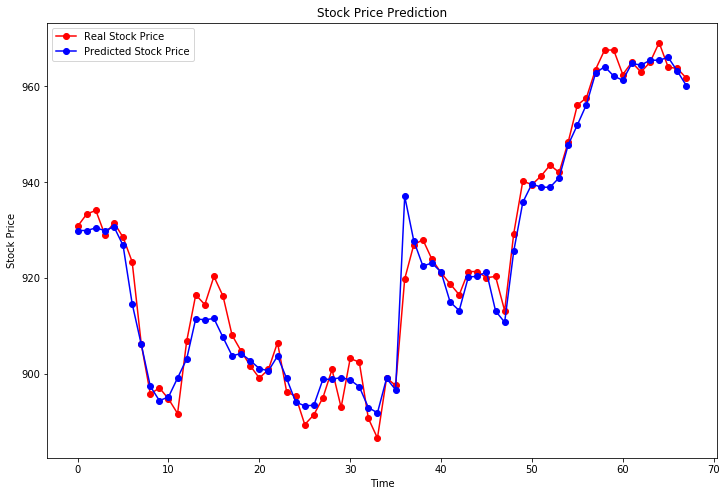

In [22]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

from sklearn.metrics import mean_squared_error as MSE
from xgboost.sklearn import XGBRegressor
reg=XGBRegressor(learning_rate=0.1, n_estimators=60, n_jobs=1)
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train), reg.score(X_test, y_test))
print(np.sqrt(MSE(y_test, reg.predict(X_test))))
predicted_stock_price = reg.predict(X_test)

#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 8) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
# create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(predicted_stock_price), 8) )
test_data[:,2] = predicted_stock_price.reshape(1,-1)
predicted_stock_price = sc.inverse_transform(test_data)[:,2]

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [17]:
reg.feature_importances_

array([0.01104221, 0.42631724, 0.5588387 , 0.00380183], dtype=float32)

In [18]:
X_whole.shape

(488, 4)

In [20]:
#Train -valid and Test split in time order
X_train = X_whole[0:420,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:420].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()
from sklearn.feature_selection import RFE
#no of features
nof_list=np.arange(1, X_train.shape[1])            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = XGBRegressor(learning_rate=0.1, n_estimators=60, n_jobs=1)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        print(n, ": ", nof)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

#['Lag1', 'Lag2', 'CHY', 'DXI','VWAP', 'VCHG']
cols = ['Lag1', 'Lag2', 'VWAP', 'VCHG']
model = XGBRegressor(learning_rate=0.1, n_estimators=60, n_jobs=1)
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_whole,y_whole)  
#Fitting the data to model
model.fit(X_rfe,y_whole)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print("Selected Features: ", selected_features_rfe)

[01:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 :  1
[01:30:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:21